In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import random
from math import *
from imutils import face_utils
import imutils

import xml.etree.ElementTree as ET

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchsummary import summary
import torchvision.transforms.functional as TF
from __future__ import print_function, division
import pandas as pd
import time
import copy
from moviepy.editor import VideoFileClip
plt.ion()

In [77]:
''' Download dataset'''
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

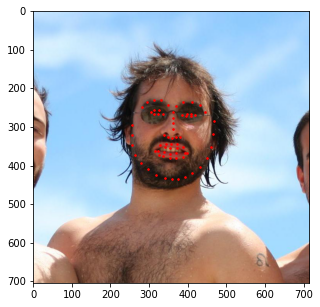

In [78]:
''' Visualise sample images '''
file=open('ibug_300W_large_face_landmark_dataset/helen/trainset/100040721_1.pts','r')
lines=file.readlines()[3:-1]

landmarks=[]

for lines in lines:
    x,y=lines.split(' ')
    landmarks.append([floor(float(x)),floor(float(y[:-1]))])

landmarks=np.array(landmarks)

plt.figure(figsize=(5,5))
plt.imshow(io.imread('ibug_300W_large_face_landmark_dataset/helen/trainset//100040721_1.jpg'))
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

plt.show()



In [15]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [80]:
class FaceLandmarkDataset(Dataset):
    def __init__(self, transform=None):
        tree=ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root=tree.getroot()

        self.image_filenames=[]
        self.landmarks=[]
        self.crops=[]
        self.transform=transform
        self.root_dir='ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
            self.crops.append(filename[0].attrib)

            landmark=[]

            for num in range(68):
                x_coord=int(filename[0][num].attrib['x'])
                y_coord=int(filename[0][num].attrib['y'])

                landmark.append([x_coord, y_coord])
            self.landmarks.append(landmark)

        self.landmarks=np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames)==len(self.landmarks)
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image=cv2.imread(self.image_filenames[idx],0)
        landmarks=self.landmarks[idx]

        if self.transform:
            image, landmarks=self.transform(image, landmarks, self.crops[idx])

        landmarks=landmarks - 0.5
        return image, landmarks

In [81]:
face_dataset=FaceLandmarkDataset(Transforms())

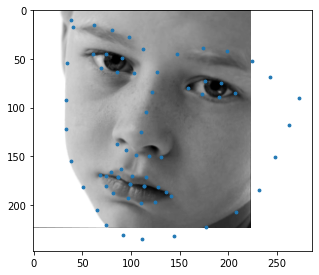

In [82]:
''' Visualising train set transform'''
image, landmarks = face_dataset[1]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(5, 5))
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.scatter(landmarks[:,0], landmarks[:,1], s=8)

In [83]:

'''splitting dataset into train and test '''

len_test=int(0.1*len(face_dataset))
len_train=len(face_dataset)-len_test

print('length of train set:',len_train)
print('length of test set:',len_test)

train, test=torch.utils.data.random_split(face_dataset, [len_train, len_test])


#shufffle batch

train_loader=DataLoader(train, batch_size=4, shuffle=True)
test_loader=DataLoader(test, batch_size=4, shuffle=True)

length of train set: 6000
length of test set: 666


In [84]:
images, landmarks=next(iter(train_loader))
print(images.shape, landmarks.shape)

torch.Size([4, 1, 224, 224]) torch.Size([4, 68, 2])


In [16]:
''' Creating the Xception Net Model'''

''' Depthwise Separable Convolution'''

class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x



''' Entry block'''


class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x

''' Middle basic Block'''
class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x

''' Exit Block'''

class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x

''' Xception Model Final'''
class XceptionNet(nn.Module):
    def __init__(self, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()

        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, 136)

    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x


    



        

        





In [86]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Test Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
''' Training loop'''


''' Loggin training metrics to tensorboard'''
#import torch.utils.tensorboard as tensorboard
#writer=tensorboard.SummaryWriter()


torch.autograd.set_detect_anomaly(True)
model=XceptionNet()
model.cuda()

criterion=nn.MSELoss()
optimiser=optim.Adam(model.parameters(),lr=0.001)
loss_min=np.inf
num_epochs=10
start_time=time.time()

for epoch in range(1, num_epochs+1):
    loss_train=0
    loss_val=0
    run_loss=0

    model.train()
    for step in range(1, len(train_loader)+1):
        images,landmarks=next(iter(train_loader))
        images=images.cuda()
        landmarks=landmarks.view(landmarks.size(0),-1).cuda()

        pred=model(images)

        optimiser.zero_grad()
        
        loss_train_step=criterion(pred, landmarks)

        loss_train_step.backward()
        optimiser.step()

        loss_train+=loss_train_step.item()
        run_loss+=loss_train/step

        print_overwrite(step,len(train_loader), run_loss,'train')

    model.eval()
    with torch.no_grad():
        for step in range(1, len(test_loader)+1):
            images, landmarks=next(iter(test_loader))
            images=images.cuda()
            landmarks=landmarks.view(landmarks.size(0),-1).cuda()
            pred.cuda()

            pred=model(images).cuda()
            loss_test_step=criterion(pred, landmarks)

            loss_test=loss_test_step.item()
            run_loss=loss_test/step

            print_overwrite(step,len(test_loader), run_loss,'test')

    loss_train=loss_train/len(train_loader)
    loss_test=loss_test/len(test_loader)
    #writer.add_scalar(loss_train, 'loss_train')
    #writer.add_scalar(loss_test, 'loss_test')


    print("/n---------------------------------------")

    print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch, loss_train, loss_test))

    if loss_test<loss_min:
        loss_min=loss_test
        torch.save(model.state_dict(), './model_best.pth')
        print("Minimum test loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))

        print("Model saving...")

print("Training complete")



    
#writer.flush()



Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch: 1, Train Loss: 0.0068, Test Loss: 0.0000
Minimum test loss of 0.0000 at epoch 1/10
Model saving...
Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch: 2, Train Loss: 0.0054, Test Loss: 0.0000
Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch: 3, Train Loss: 0.0041, Test Loss: 0.0000
Minimum test loss of 0.0000 at epoch 3/10
Model saving...
Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch: 4, Train Loss: 0.0037, Test Loss: 0.0000
Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch: 5, Train Loss: 0.0022, Test Loss: 0.0000
Minimum test loss of 0.0000 at epoch 5/10
Model saving...
Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch: 6, Train Loss: 0.0017, Test Loss: 0.0000
Test Steps: 167/167  Loss: 0.0000 /n---------------------------------------
Epoch:

In [ ]:
''' Saving model'''
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/face-landmark/face_landmark.pth')

In [29]:
''' Inference pipeline'''


#model=torch.load('/content/drive/MyDrive/Colab Notebooks/face-landmark/face_landmark.pth')
model=XceptionNet()
model.load_state_dict(torch.load('D:/Dev Projects/DeepStack/face-landmark/model/face_landmark.pth', map_location=torch.device('cpu')))
#model=torch.load()

import dlib

def transform_img(image):
  image=TF.to_pil_image(image)
  image = TF.resize(image, (224, 224))
  image = TF.to_tensor(image)
  image = (image - image.min())/(image.max() - image.min())
  image = (2 * image) - 1
  return image.unsqueeze(0)


def landmarks_draw(image,img_landmarks):
  image=image.copy()
  for landmarks, (left, top,height,width) in img_landmarks:
    landmarks=landmarks.view(-1,2)
    landmarks=(landmarks+0.5)
    landmarks=landmarks.numpy()

    for i, (x,y) in enumerate(landmarks, 1):
      try:
        cv2.circle(image, (int((x * width) + left), int((y * height) + top)), 2, [40, 117, 255], -1)
      except:
        pass
  return image




detector=dlib.get_frontal_face_detector()

@torch.no_grad()


def inference(frame):
  gray=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  faces=detector(gray,1)

  outputs=[]

  for (i, face) in enumerate(faces):
    (x, y, w, h) = face_utils.rect_to_bb(face)
    crop_img = gray[y: y + h, x: x + w]
    
    transformed_img= transform_img(crop_img)
    landmarks_predictions = model(transformed_img.cpu())
    outputs.append((landmarks_predictions.cpu(), (x, y, h, w)))
  return landmarks_draw(frame, outputs)


''' inference on video'''

def output_video(video, name, seconds = None):
    start_time=time.time()
    total = int(video.fps * seconds) if seconds else int(video.fps * video.duration)
    print('Will read', total, 'images...')
    
    outputs = []

    writer = cv2.VideoWriter(name + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), video.fps, tuple(video.size))

    for i, frame in enumerate(tqdm(video.iter_frames(), total = total), 1):    
        if seconds:
            if (i + 1) == total:
                break
                
        output = inference(frame)
        outputs.append(output)

        

        writer.write(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
    end_time=time.time()
    print("Model inference Time taken: {:.2f} seconds".format(end_time-start_time))

    

    writer.release()

    return outputs


''' inference on image'''


def image_output(image, name):
  print("Analysing image")
  #frame=cv2.imread(image)
  start_time=time.time()


  outputs=[]

  #writer=cv2.imwrite('img.jpg', image)

  output=inference(image)
  outputs.append(output)

  #writer=(cv2.cvtColor(output,cv2.COLOR_RGB2GRAY))
  writer=output
  disp_img=cv2.imwrite('img.jpg',writer)

  end_time=time.time()

  process_time=end_time-start_time

  print("Processing time: {:.2f} seconds".format(process_time))

  #writer.release()

  return outputs









(2160, 3840, 3)


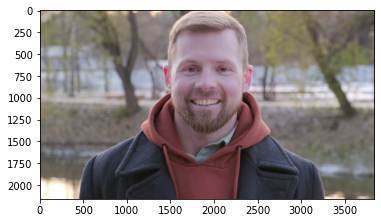

In [ ]:
vid=VideoFileClip('/content/drive/MyDrive/Colab Notebooks/face-landmark/video.mp4')

for frame in vid.iter_frames():
  break

print(frame.shape)
plt.figure(figsize=(6,6))
plt.imshow(frame)

In [ ]:
outputs=output_video(vid,'vid_output')

plt.figure(figsize=(11,11))
plt.imshow(outputs[2])

Analysing image
Processing time: 1.02 seconds


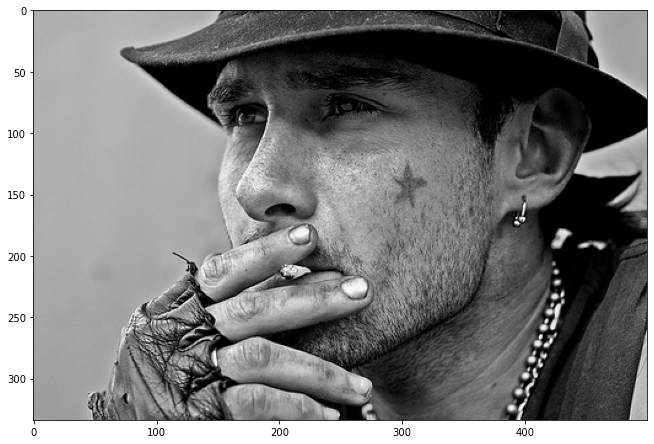

In [30]:
img=cv2.imread('D:/Dev Projects/DeepStack/face-landmark/data/faces/152601997_ec6429a43c.jpg')
outputs=image_output(img,'img_output')

plt.figure(figsize=(11,11))
plt.imshow(outputs[0])